# BasicQC Tutorial

The Summary statistics and QC tutorial is intended as a functional guide to help assess the quality characteristics of a single Nanopore sequencing run. This tutorial aims to enable an objective assessment of the performance of a Nanopore flowcell run and to assess the sequence characteristics to benchmark quality.

Sufficient information is provided in the tutorial that the workflow can be tested, validated and replicated. The tutorial is provided with an example dataset from a barcoded sequence library. The tutorial is intended to address important questions;

* How many reads (and how many gigabases) were sequenced?
* What fraction of my sequence collection is good quality?
* How are longer sequence reads represented in my sample?
* How uniform is the representation of different barcodes?

Methods used in this tutorial include:

- Python for statistical analysis and reporting (modules used include `pandas`, `numpy`, `dask` and other modules used for data science and genome bioinformatics) 
- `sequencing_summary.txt` as data source for parsing

Computational requirements for this tutorial include:

- Computer running the **Epi2Me Labs** notebook Server
- At least 8 Gb RAM
- Runtime with provided example data - approximately 10 minutes



## Introduction

This tutorial aims to summarise the data characteristics from an Oxford Nanopore Technologies sequencing run. Observations from basecalled reads and their quality characteristics, temporal performance, and barcoded content are presented. The information presented is derived solely from the `sequence_summary.txt` file produced during basecalling with the Guppy software. 

The goals from this tutorial include:

* To introduce a literate framework for analysing base-calling summary
statistics to evaluate the relative performance of runs.
* To provide basic QC metrics so that a review and consideration of experimental data can be undertaken.
* To provide training as to which QC metrics are of most interest and to encourage an understanding of how different aspects of sequence data quality can be attributed to sample characteristics from DNA isolation and library preparation.

Several of the plots included in this report have been replicated from publicly available projects such as [POREquality](https://github.com/carsweshau/POREquality) [minion_qc](https://github.com/roblanf/minion_qc), [NanoPlot](https://github.com/wdecoster/NanoPlot) and [pycoQC](https://github.com/a-slide/pycoQC)



### The `sequencing_summary.txt` file

The `sequencing_summary.txt` file is automatically produced during base-calling with the Guppy software. This summary file contains rich metadata for each sequence read produced during a run. These data include timestamp, pore duration, read quality, and channel information, in addition to the characteristics of the resulting DNA sequence. This workflow presented here uses this summary file rather than the raw `FAST5` format data for performance reasons.

Tools such as [pomoxis](https://github.com/nanoporetech/pomoxis) utilise the fastq files for quality metrics, and other tools make extensive use of the fast5 files. Parsing the fast5 files provides additional analytical context but is much more demanding in terms of compute resource and time. This tutorial is lightweight and is intended to run within a few minutes on a desktop computer.


# Basic QC analysis and results

### Download example data

> Need to explain how to get example data, or set your own
> 1. RawData/lambda_sequencing_summary.txt.bz2 is a summary statistic file describing approximately 1 million sequence reads from a barcoded lambda DNA sequencing run. These sequence reads have been base-called using the Guppy software. This file has been bzip2 compressed.
> 2. RawData/lambda_barcoding_summary.txt.bz2 is a barcode summary statistic file describing the barcode assignments for the sequence reads. This barcode assignment has been performed using the Guppy software.

## Import the required Python modules

This `BasicQC tutorial` is implemented in the Python language. To run the analysis workflow using the `papermill` software requires that a number of other Python dependencies are loaded


In [0]:
import sys
print("{}\n{}".format(sys.executable, sys.version))
import logging
from importlib import reload
reload(logging)
logging.basicConfig(format="%(asctime)s %(levelname)s:%(message)s", 
                    level=logging.INFO, datefmt="%d.%b.%y(%I:%M:%S)")
from bokeh.io import output_notebook
output_notebook()
from IPython.display import Image, display, Markdown, HTML
from megrim.basic_qc import SequenceSummaryHandler

/Users/stephen/miniconda3/envs/ont-tutorial-basicqc2/bin/python
3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]


Loading BokehJS ...

## Reading configuration parameters for BasicQC workflow

The `BasicQC` tutorial requires a pointer to a **`Sequencing_summary.txt`** 
file that has been produced by the **`Guppy`** software during the base-calling 
process. 

The path to the **`sequencing_summary`** file may be provided to the workflow vignette 
using two different approaches.

1. The **`ont_tutorial_basicqc.ipynb`** workbook may be edited using the Jupyter 
software to specify the file path. This should be qualified in the **`filename`**
parameter in the code-block below.
1. A filename parameter may be provided to the script at runtime. This approach is
simpler and is demonstrated in the workflow at the top of this document. The
parameter specification is performed with the **`papermill -p filename <YOUR FILENAME>`**
command.



In [0]:
filename = "/Users/stephen/Documents/Python_code/megrim/megrim/Tutorials/basic_qc/lambda_sequencing_summary.txt.bz2"
barcodes = None

## Load the specified `filename` into `megrim`

The sequence information contained within the `sequencing_summary.txt` file specified by the *`filename`* parameter is loaded into computer memory. The Python package that performs the file parsing, `megrim`, can read `sequencing_summary.txt` files that have been compressed with `gzip` or `bzip2` methods. When compressed files are loaded a warning may be given.

In [0]:
ssh = SequenceSummaryHandler(filename)
ssh.set_plot_type("screenshot") # this will be applied to subsequent figures ...
ssh.set_plot_tools("")

20.Jan.20(11:11:26) WARNING:reading a bzip2 file - this has performance implications
20.Jan.20(11:11:53) WARNING:Dask ValueError during import - filtering for duplicate headers


[########################################] | 100% Completed |  1.3s
Elapsed time to extract sequence data 00:00:01


## Executive summary

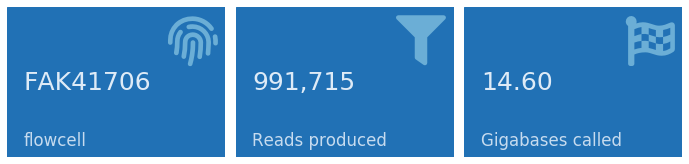

In [0]:
ssh.executive_summary(plot_width=1000)


Basecalling was performed using a software package called Guppy. Called reads were classified as either `pass` or `fail` depending on their mean quality score. The infographic plot above, and the dial plot below summarise the number of reads described within the `sequencing_summary.txt` file and the volumes of data that are either passed or failed on the basis of the quality_threshold applied during the base-calling process.


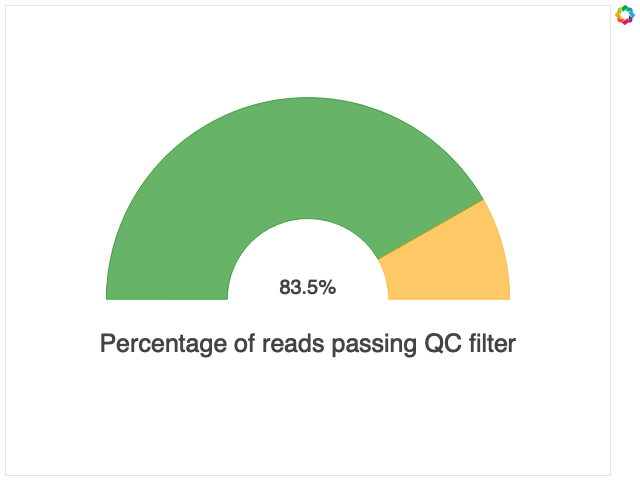

In [0]:
ssh.plot_passed_gauge()

## Sequencing channel activity plot

The nanopores through which DNA is passed, and signal collected, are arrayed as a 2-dimensional matrix. A heatmap can be plotted showing channel productivity against spatial position on the matrix. Such a plot enables the identification of spatial artifacts that could result from membrane damage through e.g. the introduction of an air-bubble. This heatmap representation of spatial activity shows only gross spatial aberations. Since each channel can address four differemnt pores (Mux) the activity plot below shows the number of sequences produced per channel, not per pore. 


20.Jan.20(11:12:28) INFO:rotating MinION data


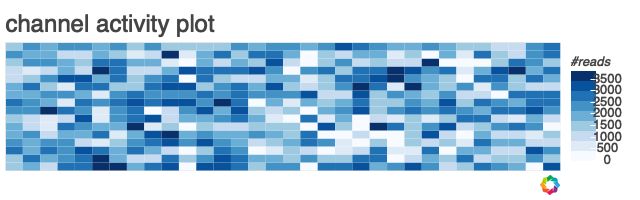

In [0]:
ssh.plot_channel_activity(plot_height=200)

## Quality and length

The distribution of base-called DNA sequence lengths and their accompanying qualities are key metrics for the review of a sequencing library. This section of the QC review tutorial assesses the length and quality distributions for reads from this flowcell. We will review the total collection of sequences, including those that fail the mean quality filter. The information plot below summarises key metrics from the sequence library. Mean read length, N50, mean read quality and longest read are calculated from the reads that pass the QC threshold. Mean failed QC is calculated from only the reads that failed QC.



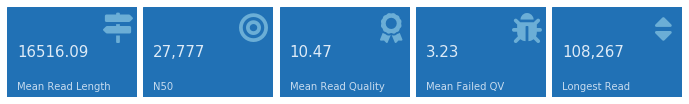

In [0]:
ssh.library_characteristics_infographic(plot_width=1000)

The distribution of sequence lengths will be dependent on the protocols that have been used to extract and/or prepare the starting DNA. Sequences from amplicon DNA will have a tight distribution of read lengths, while sequences from genomic DNA will have a broader distribution. The distribution will be further influenced if a size-selection step has been used, and will also be dependent on the choice of sequencing library preparation kits. The read-length distribution should be assessed to see if the distribution is concordant with that expected.


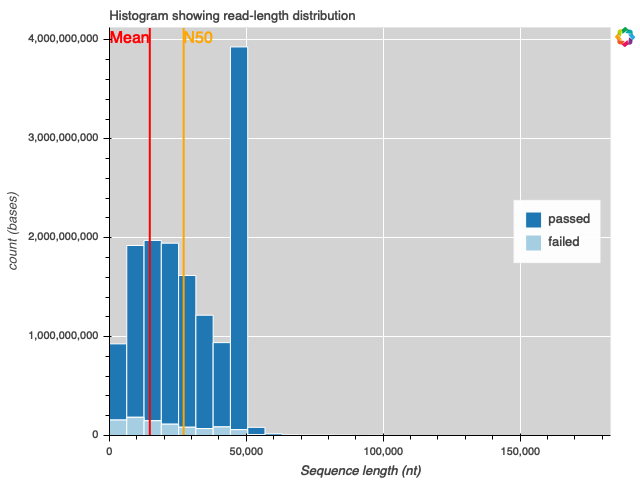

In [0]:
ssh.plot_sequence_length()


The weighted read length histogram above shows the binned distribution of sequence length against number of sequence nucleotides contained within the bin. This plot will show clear peaks if for example, amplicons are sequenced or if size selection has been performed. The histogram includes annotations for N50 and mean sequence sizes. N50 describes the sequence length where 50% of the sequenced bases are contained within reads of this length, or longer. The mean sequence length is the average sequence length across the whole sequence collection. The N50 and mean sequence lengths plotted are calculated from only the sequence reads that pass QC.



20.Jan.20(11:12:34) INFO:using read counts instead of bases!


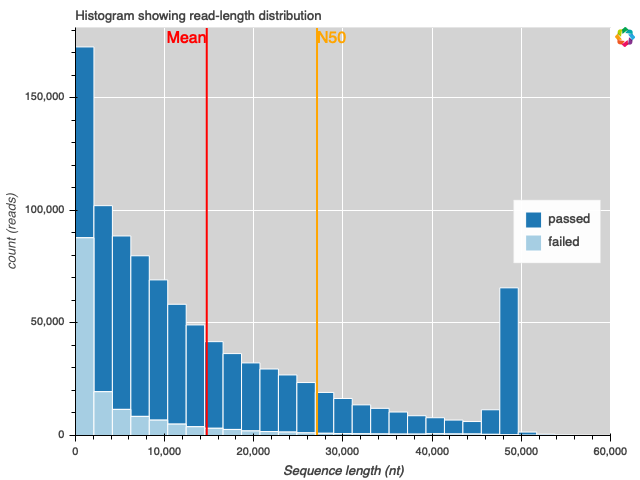

In [0]:
ssh.plot_sequence_length(normalised=False, longest_read=60000)

A histogram of mean QV scores reveals the relative abundance of sequences of different qualities. The distribution of sequence qualities is shaded by the QV filter pass status. This QV filter is applied during the base-calling process as a modifiable parameter. For downstream analyses we recommend processing only the higher-quality sequence reads. The histogram includes annotations for N50 and mean sequence sizes. N50 describes the sequence length where 50% of the sequenced bases are contained within reads of this length, or longer. The mean sequence length is the average sequence length across the whole sequence collection. The N50 and mean sequence lengths plotted are calculated from only the sequence reads that pass QC.


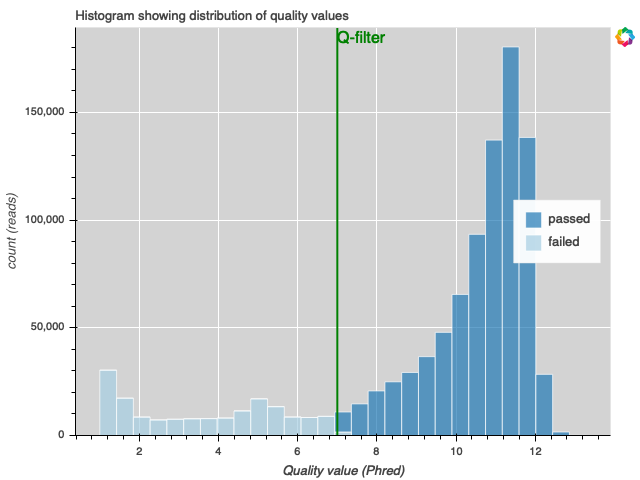

In [0]:
ssh.plot_q_distribution()

The plot above shows the distribution of mean read quality scores across the whole sequence collection. The distribution has been shaded for the sequence reads that have passed or failed the base-callers quality filter.


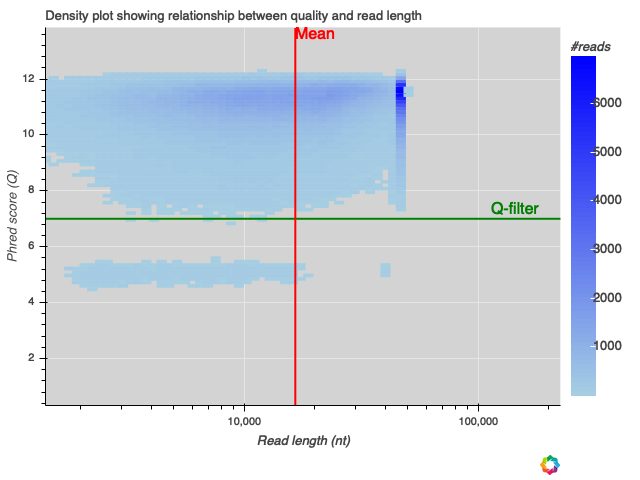

In [0]:
ssh.plot_q_l_density(plot_depth_threshold=75)

The density plot of mean sequence quality plotted against log10 sequence length is a useful graphic to show patterns within the broader sequence collection. The density plot shown in the figure below has been de-speckled by omitting the rarer sequence bins containing only a few reads - this can be controlled by adjusting the `plot_depth_threshold` parameter (this is very important for `flongle`-runs). This is mainly aesthetic and masks some speckle around the periphery of the main density map. 


## Time/duty performance

Another key metric in the quality review of a sequencing run is an analysis of the temporal performance of the run. During a run each sequencing channel will address a number of different pores (mux) and the individual pores may become temporarily or permanently blocked. It is therefore expected that during a run sequencing productivity will decrease. It is useful to consider whether the observed productivity decline is normal or if it happens more rapidly than expected. A rapid pore decline could be indicative of contaminants with the sequencing library.

Plotting the number of bases generated per unit time over the course of a sequencing run can reveal unexpected behaviours. In an ideal experiment there should not be any sudden decreases in performance.


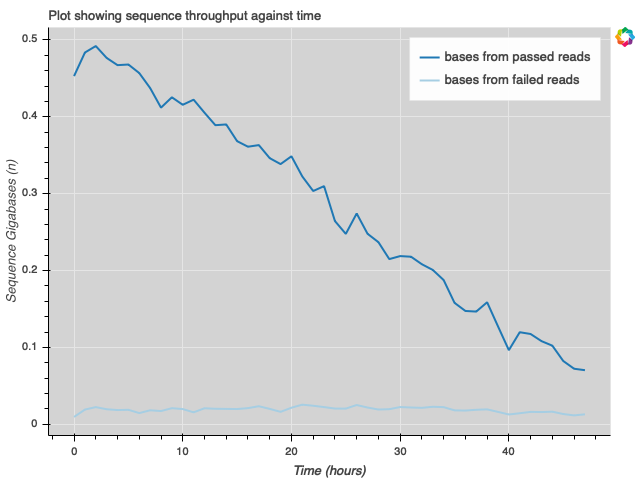

In [0]:
ssh.plot_time_duty_bases(cumulative=False)

The temporal data presented in the figure above has been scaled to gigabases of sequence produced per hour. For a finer resolution of performance the parameters used in the preparation of this figure can be modified for a more frequent sample interval. 


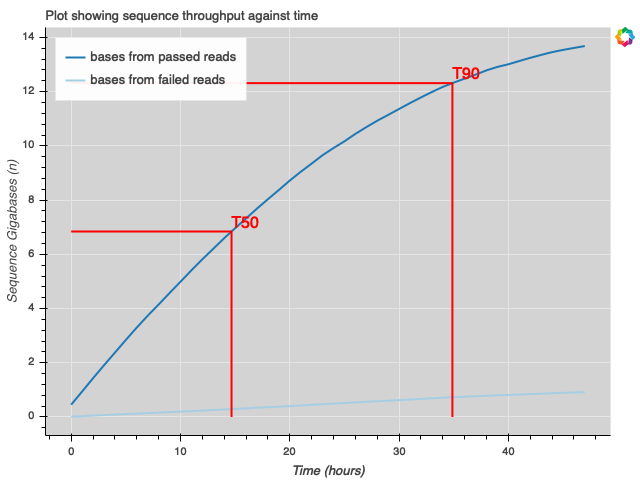

In [0]:
ssh.plot_time_duty_bases()

In addition to plotting the temporal production of data, the cumulative plot shown above shows how data is accumulated during the run. We can identify the timepoint T50, where 50% of sequenced bases have been collected within this time. This is displayed on the graph along with T90, the time at which 90% of the sequenced based have been acquired.

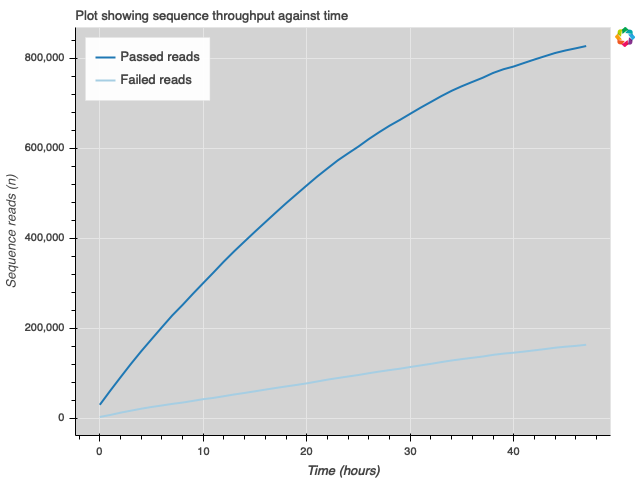

In [0]:
ssh.plot_time_duty_reads()

In addition to the cumulative plot of sequenced bases, an equivalent plot for the sequenced reads can be plotted - this is shown in the figure above. This is not too dissimilar in structure or morphology to the cumulative baseplot. 


The speed/time plot (below) is a useful tool to observe any substantial changes in sequencing speed. A marked slow-down in sequencing speed can indicate challenges within the sequencing chemistry that could have been caused by the method of DNA isolation or an abundance of small DNA fragments. Please contact our technical team if you see a profound slowdown with your sequencing.

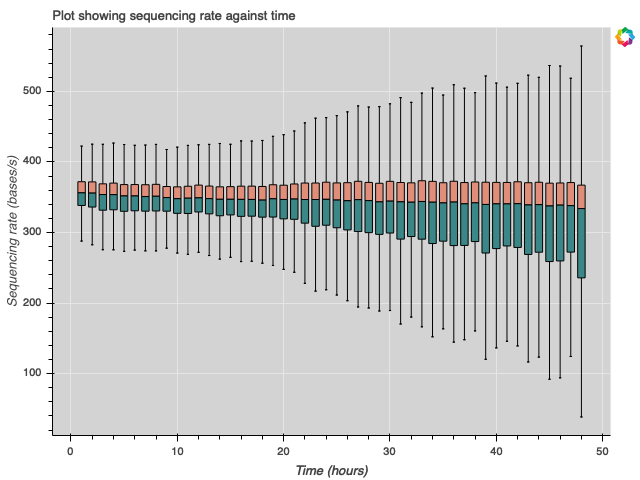

In [0]:
ssh.plot_translocation_speed()

The data points shown in the speed-time plot shown above have been filtered to mask outlying sequences (sequences beyond the 95% range). The distribution of the boxplots and their 'whiskers' are unchanged.


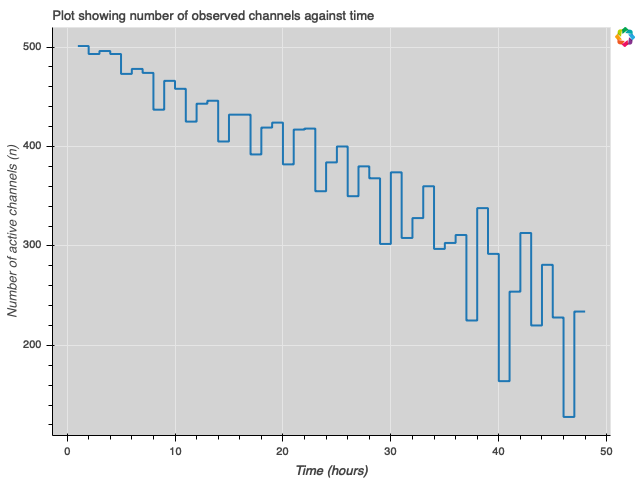

In [0]:
ssh.plot_functional_channels()

The graph presented above shows the number of sequencing channels that are actively producing data across time. A channel is defined as being active if one or more sequence reads are observed per time window (one hour for the default graph). It is expected that over the course of the run pores will block and the number of channels producing data will decrease. Changing the pore used by the channel (mux) and strategies to unblock pores mean that the number of functional channels may increase or decrease at a given timepoint but generally the number of channels producing data will decrease over time.

## Demultiplexing

20.Jan.20(11:12:42) INFO:importing barcode file /Users/stephen/Documents/Python_code/megrim/megrim/Tutorials/basic_qc/lambda_barcoding_summary.txt.bz2


[########################################] | 100% Completed | 31.0s


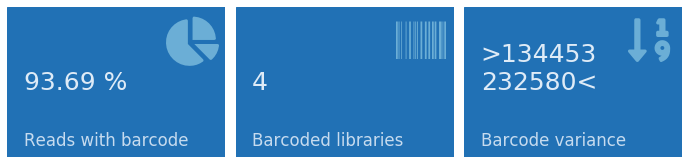

In [0]:
# this code allows for use of barcoding_summary files from guppy_barcoding
# please see the section below on customising the tutorial
if not ssh.is_barcoded_dataset() and barcodes is not None:
    ssh.merge_barcodes_file(barcodes)
ssh.plot_barcode_info(plot_width=1000)  

In [0]:
display(ssh.tabulate_barcodes())
if ssh.is_barcoded_dataset():
    display(Markdown("The table above shows summary statistics for the barcode assignments within this sequence collection. The annotated barcode is presented along with the number of sequence reads assigned to it (freq), the percentage of reads assigned to the barcode (%), the megabases of DNA sequence (Mb), shortest read in nucleotides (min), longest read in nucleotides (max), mean sequence length in nucleotides (mean) and N50 and L50 values, again in nucleotides."))

,count,%,mean_q,Mbases,min,max,mean,N50
,,,,,,,,
barcode01,192808,23.27,10.58,3337311981,102,103385,17308.99,28690
barcode02,216317,26.11,10.57,3524856127,104,107212,16294.86,27455
barcode03,134453,16.23,10.58,2296929897,82,108267,17083.52,28655
barcode04,232580,28.07,10.56,3846310148,101,101790,16537.58,28117
unclassified,52287,6.31,9.28,677352185,5,90216,12954.50,22483


The table above shows summary statistics for the barcode assignments within this sequence collection. The annotated barcode is presented along with the number of sequence reads assigned to it (freq), the percentage of reads assigned to the barcode (%), the megabases of DNA sequence (Mb), shortest read in nucleotides (min), longest read in nucleotides (max), mean sequence length in nucleotides (mean) and N50 and L50 values, again in nucleotides.

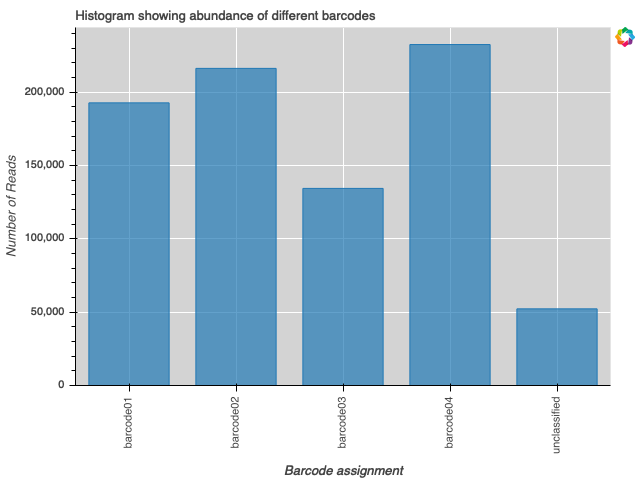

The histogram above shows the abundance of different barcodes within the sequence collection. The size of the bar corresponds to the frequency of the observation - this is the number of sequence reads observed.

In [0]:
display(ssh.plot_barcodes())
if ssh.is_barcoded_dataset():
    display(Markdown("The histogram above shows the abundance of different barcodes within the sequence collection. The size of the bar corresponds to the frequency of the observation - this is the number of sequence reads observed."))

### Demo of barcode subset ... quality scores for the unclassified reads

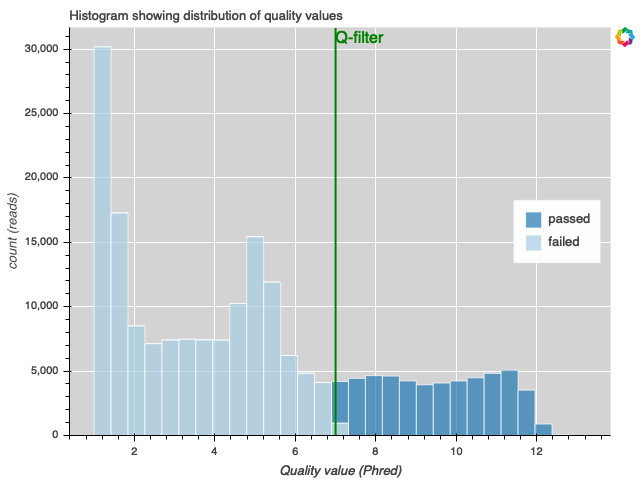

In [0]:
if ssh.is_barcoded_dataset():
    display(Markdown("### Demo of barcode subset ... quality scores for the unclassified reads"))
    ssh_unc = ssh.barcode_subset("unclassified")
    display(ssh_unc.plot_q_distribution())

# Reproducible Research

This report has been created using **`papermill`**, publicly available **`Python`** modules, and the **`nbconvert`** `.ipynb` typesetting software for reproducibility. For clarity the operating system and `Python` modules used, and their versions, is listed below.


In [0]:
from megrim.reproducible_research import *
print(SessionInfo())

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27)
Platform: x86_64-Darwin
Running under: Darwin-19.2.0-x86_64-i386-64bit

locale: (None, 'UTF-8')
attached modules:
   [1]          IPython {7.11.1}              PIL {7.0.0}            appnope {0.1.0} 
   [4]            argparse {1.1}         backcall {0.1.0}              bokeh {1.4.0} 
   [7]             cffi {1.13.2}      cloudpickle {1.2.2}                  csv {1.0} 
   [10]           ctypes {1.1.0}          curses {b'2.2'}            cycler {0.10.0} 
   [13]             dask {2.9.2}         dateutil {2.8.1}             decimal {1.70} 
   [16]        decorator {4.4.1}        distutils {3.7.6}       fontawesome {5.10.1} 
   [19]           fsspec {0.6.2}        ipykernel {5.1.3}   ipython_genutils {0.2.0} 
   [22]       ipywidgets {7.5.1}            jedi {0.15.2}            jinja2 {2.10.3} 
   [25]             json {2.0.9}   jupyter_client {5.3.4}       jupyter_core {4.6.1} 
   [28]       kiwisolver {1.1

# Customise the tutorial and explore your own data

Final thoughts; behind this **`.ipynb`** file is a modest amount of **`Python code`** - please explore the **`.ipynb`** template; modify it, and run with your own samples.

The **`basic_qc_tutorial.ipynb`** document contains the Python code to perform the QC analysis. The sequence summary file to report is specified within the file. Please edit the file to point to your own summary file. As a recommended best practice, place the summary file into the **`RawData`** folder within your project directory. The summary file may be compressed  (compress with either **`.gz`** or **`.bz2`**).

The **`basic_qc_tutorial.ipynb`** files can be edited directly using **`jupyter-lab`**. The code below shows the command to open the **`.ipynb`** template file with the **`jupyter-lab`** software.

```bash
jupyter-lab basic_qc_tutorial
```

### Barcoding applications

The standard workflow for this tutorial assumes that barcode assignments are called by `Guppy` during the base-calling process. The `Guppy` software also allows for base-calling to be performed on `FASTQ` format sequence files using the `guppy-barcoder` application. The `guppy-barcoder` application does not place the `barcode_arrangement` information into the `sequencing_summary.txt` file but writes the sequence to barcode mapping information into a file called `barcoding_summary.txt`. It is possible to include these information into this tutorial code. To include these information either edit the `barcodes` field in the `basic_qc_tutorial.ipynb` file or (recommended) run the `papermill` workflow with

```bash
papermill -p filename <seqsum.txt> barcodes <barcode.txt> basic_qc_tutorial.ipynb tutorial_output.ipynb
```
> where `<seqsum.txt>` will be a fully qualified path to your `sequencing_summary.txt` file and `<barcode.txt>` will be a fully qualified path to your `barcoding_summary.txt` file


# Glossary of terms

- **`FAST5`** (file format)
- **`.ipynb`** (file format) - this is the **`IPython notebook`** file format. This is widely used in bioinformatics and enables literate programming and data-mining
- **`Jupyter`** (software) - 
- **`L50`** - describes the number of sequences (or contigs) that are longer than, or equal to, the N50 length and therefore include half the bases of the assembly
- **`N50`** - describes the length (read length, contig length etc) where half the bases of the sequence collection are contained within reads/contigs of this length or longer
- **`nbconvert`** (software) - this is used to convert the **`.ipynb`** format files into an accessible **`.html`** format file for sharing and visualisation in web-browser of choice
- **`papermill`** (software) - this runs the analyses within the **`.ipynb`** template file and produces the tables of results and figures
- **`QV`** - aquality value, `-log10(p)` that any given base is incorrect. QV may be either at the individual base level, or may be averaged across whole sequences
- **`sequencing_summary.txt`** - a summary file describing sequence characteristics following base calling with the Guppy software.

# References and citations